In [2]:
import pandas as pd
import joblib
import seaborn as sb
import matplotlib.pyplot as plt
import truvari
import scipy.stats as scistat
sb.set()

In [3]:
data = joblib.load("../temp/grch38_HG01596.bench.jl")

In [4]:
data["TRF"] = data["TRF"].where(~data["TRF"].isna(), False)
base_calls = data[data["state"].isin(["tpbase", "fn"])].copy()
base_calls["TRFrepeat_len"] = base_calls["TRFrepeat"].apply(lambda x: len(x) if x else 0)
base_calls["Repeat"] = base_calls["RM_clsfam"].where(base_calls["RM_score"] >= 225, None).apply(lambda x: x.split('/')[0] if x else None)
base_calls["NumNeighbor_bins"] = pd.cut(base_calls["NumNeighbors"], 
                                        bins=[0, 1, 5, 10, 50, base_calls["NumNeighbors"].max()], 
                                        labels=["0", "1", "(1,5]", "(5,10]", "10+"])



In [5]:
base_calls[base_calls["DIPCOV"]].groupby(["svtype", "state", "TRF"]).size().unstack()["DEL":"INS"]

TRF            False  True
svtype state              
DEL    tpbase   1062  2726
       fn        112  1951
       tp          0     0
       fp          0     0
INS    tpbase   1871  1461
       fn       1290  4062
       tp          0     0
       fp          0     0

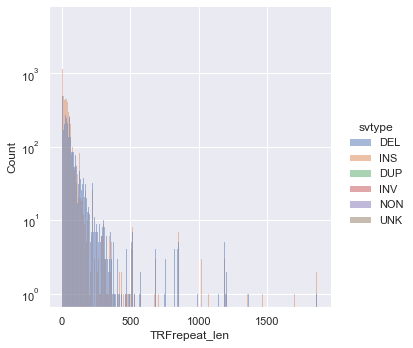

In [6]:
p = sb.displot(data=base_calls.reset_index(),
               x="TRFrepeat_len", hue="svtype")#, kind="kde")
p.set(yscale="log")

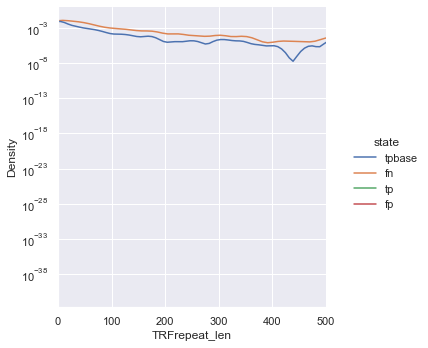

In [7]:
p = sb.displot(data=base_calls[base_calls["svtype"] == "INS"].reset_index(),
               x="TRFrepeat_len", hue="state", kind="kde")
p.set(yscale="log", xlim=(0, 500))

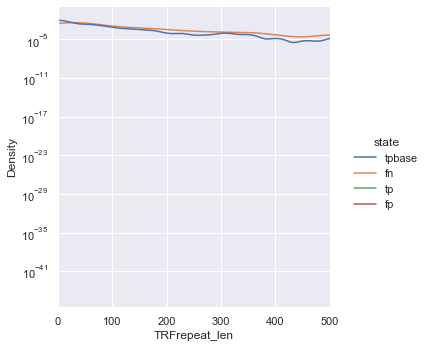

In [8]:
p = sb.displot(data=base_calls[base_calls["svtype"] == "DEL"].reset_index(),
               x="TRFrepeat_len", hue="state", kind="kde")
p.set(yscale="log", xlim=(0, 500))

In [9]:
base_calls.groupby(["Repeat", "TRF", "state"]).size().sort_values(ascending=False).unstack()

state                 tpbase   fn  tp  fp
Repeat         TRF                       
DNA            False       3    0   0   0
               True        1    0   0   0
LINE           False      83  169   0   0
               True       58   23   0   0
LTR            False      26    8   0   0
               True        5   13   0   0
Low_complexity False       0   14   0   0
               True        0   44   0   0
Retroposon     False       0   38   0   0
               True       33   14   0   0
SINE           False     912  591   0   0
               True      647   83   0   0
Satellite      False       0    1   0   0
               True        1    2   0   0
Simple_repeat  False       7   94   0   0
               True       72  445   0   0
rRNA           False       0    1   0   0
               True        0    0   0   0

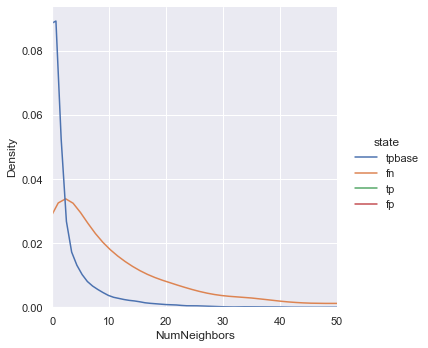

In [11]:
p = sb.displot(data=base_calls.reset_index(), x="NumNeighbors", hue="state", kind="kde")
p.set(xlim=(0, 50))#, yscale="log")

In [13]:
base_calls.groupby(["NumNeighbor_bins", "state"]).size().unstack()

state,tpbase,fn,tp,fp
NumNeighbor_bins,,,,
0,1063,1153,0,0
1,1609,3109,0,0
"(1,5]",667,2544,0,0
"(5,10]",570,5004,0,0
10+,21,850,0,0


In [14]:
base_calls["DIPCOV"].value_counts()

True     14535
False     9845
Name: DIPCOV, dtype: int64

[(0.0, 100.0)]

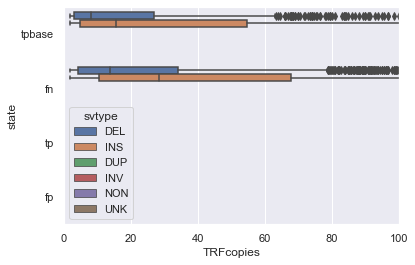

In [15]:
p = sb.boxplot(data=base_calls, x="TRFcopies", y="state", hue="svtype")
p.set(xlim=(0, 100))

In [16]:
base_calls.groupby(["svtype", "state"])["TRFcopies"].describe()

count       mean         std  min   25%        50%        75%  \
svtype state                                                                    
DEL    tpbase  3596.0  43.710285  694.062195  1.8   2.9   8.000000  27.000000   
       fn      4156.0  48.016724  399.423126  1.8   4.2  13.900000  34.000000   
INS    tpbase  2061.0  93.253319  876.454895  1.8   4.9  15.700000  54.799999   
       fn      8783.0  94.256294  546.015381  1.8  10.4  28.299999  67.949997   

                        max  
svtype state                 
DEL    tpbase  26436.599609  
       fn      13076.400391  
INS    tpbase  26436.599609  
       fn      17060.400391

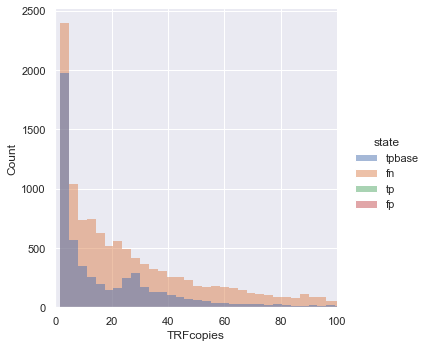

In [17]:
p = sb.displot(data=base_calls.reset_index(), x="TRFcopies", hue="state")
p.set(xlim=(0, 100))

[(0.0, 1000.0), (0.0, 500.0)]

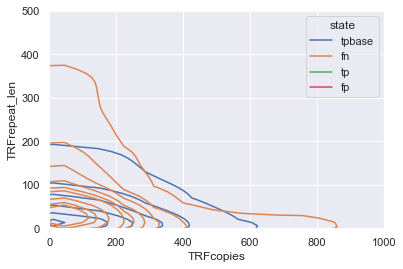

In [18]:
p = sb.kdeplot(data=base_calls.reset_index(), x="TRFcopies", y="TRFrepeat_len", hue="state")
p.set(xlim=(0, 1000), ylim=(0, 500))

In [19]:
subset = (base_calls["TRFcopies"] <= 500) & (base_calls["TRFrepeat_len"] <= 250)
subset = base_calls[subset]

In [20]:
a = pd.cut(subset["TRFcopies"], bins=10)
b = pd.cut(subset["TRFrepeat_len"], bins=5)

In [21]:
j = pd.concat([a, b, subset["state"]], axis=1)

In [22]:
t = j[j["state"] == 'tpbase'].groupby(["TRFcopies", "TRFrepeat_len"]).size()
f = j[j["state"] == 'fn'].groupby(["TRFcopies", "TRFrepeat_len"]).size()

In [23]:
x = (t / (t + f)).unstack()

<AxesSubplot:>

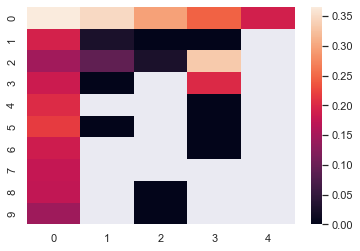

In [24]:
sb.heatmap(x.values)

In [25]:
x

TRFrepeat_len,"(0.752, 50.6]","(50.6, 100.2]","(100.2, 149.8]","(149.8, 199.4]","(199.4, 249.0]"
TRFcopies,,,,,
"(1.302, 51.62]",0.365567,0.347209,0.295918,0.244526,0.189427
"(51.62, 101.44]",0.192135,0.026490,0.000000,0.000000,NaN
"(101.44, 151.26]",0.146487,0.090909,0.026316,0.333333,NaN
"(151.26, 201.08]",0.183486,0.000000,NaN,0.200000,NaN
"(201.08, 250.9]",0.202186,NaN,NaN,0.000000,NaN
"(250.9, 300.72]",0.215827,0.000000,NaN,0.000000,NaN
"(300.72, 350.54]",0.185567,NaN,NaN,0.000000,NaN
"(350.54, 400.36]",0.175676,NaN,NaN,NaN,NaN
"(400.36, 450.18]",0.173077,NaN,0.000000,NaN,NaN


In [26]:
# As Repeat Length ncreases, the discoverability lowers.

[(0.0, 100.0)]

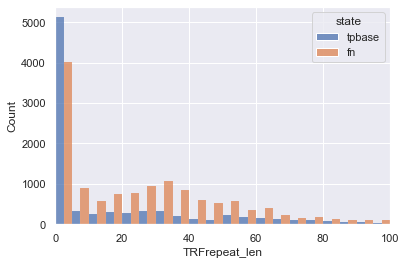

In [27]:
p = sb.histplot(data=base_calls.reset_index(), 
                x="TRFrepeat_len", 
                hue="state", 
                binwidth=5, 
                multiple="dodge",
                hue_order=["tpbase", "fn"])
p.set(xlim=(0,100))

[(0.0, 100.0)]

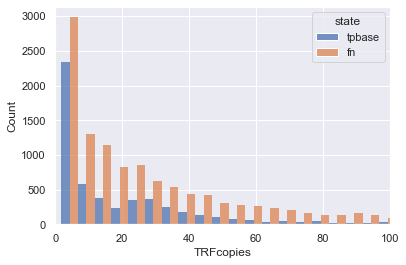

In [28]:
p = sb.histplot(data=base_calls.reset_index(), 
                x="TRFcopies", 
                hue="state", 
                binwidth=5, 
                multiple="dodge",
                hue_order=["tpbase", "fn"])
p.set(xlim=(0,100))

In [38]:
from sklearn.feature_selection import SelectKBest, chi2

In [39]:
from sklearn import preprocessing

In [40]:
le = preprocessing.LabelEncoder()
le.fit(base_calls["Repeat"].unique())
base_calls["Repeat_enc"] = le.transform(base_calls["Repeat"])

In [41]:
base_calls["svtype_enc"] = base_calls["svtype"].cat.codes

In [42]:
features = ["svtype_enc", "svlen", "TRFrepeat_len", "Repeat_enc", "NumNeighbors", "TRFcopies"]

In [43]:
use = ~base_calls[features].isna().any(axis=1)
subset = base_calls[use].reset_index()

In [44]:
X_new = SelectKBest(chi2, k="all").fit_transform(subset[features], subset["state"] == "tpbase")

In [45]:
X_new.mean(axis=0)

array([  0.58313616, 349.2196709 ,  56.20832437,   8.7179501 ,
        12.34028823,  74.03677157])

In [46]:
j = pd.Series(X_new.mean(axis=0), index=features, name="Feature Ranking").reset_index()

[None]

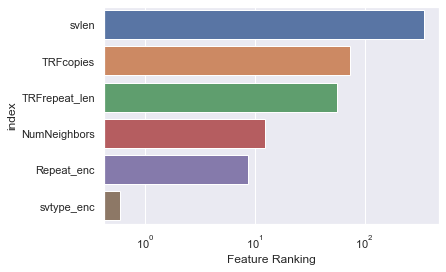

In [47]:
p = sb.barplot(data=j.sort_values(["Feature Ranking"], ascending=False), 
               y="index", 
               x="Feature Ranking")
p.set(xscale="log")

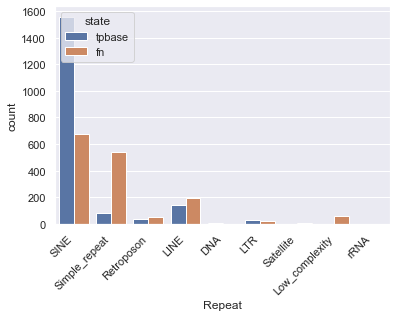

In [48]:
sb.countplot(data=base_calls, x="Repeat", hue="state", hue_order=["tpbase", "fn"])
hide = plt.xticks(rotation=45, ha="right")